In [236]:
import data_preprocess as dp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from importlib import reload
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [237]:
df=dp.get_data()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1728 entries, 2015-01-01 to 2021-12-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1728 non-null   float64
 1   Low        1728 non-null   float64
 2   Open       1728 non-null   float64
 3   Close      1728 non-null   float64
 4   Volume     1728 non-null   float64
 5   Adj Close  1728 non-null   float64
 6   x0         1728 non-null   float64
dtypes: float64(7)
memory usage: 108.0 KB


,High,Low,Open,Close,Volume,Adj Close,x0
Date,,,,,,,
2015-01-01,441.812073,437.676270,438.988831,439.781311,1367720.0,419.247345,1.0
2015-01-02,443.818054,437.998199,439.880371,438.617340,3383424.0,418.137726,1.0
2015-01-05,441.267212,432.946106,438.344940,433.812897,4662967.0,413.557648,1.0
2015-01-06,432.401276,412.093750,430.915344,414.124512,8596809.0,394.788513,1.0
2015-01-07,425.367950,414.570282,414.619812,423.139069,9562421.0,403.382141,1.0


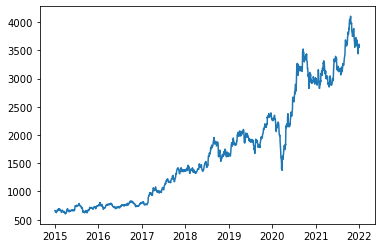

In [238]:
plt.plot(df["High"]+df["Low"]/2)
plt.show()

In [239]:
mid=df["High"]+df["Low"]/2
test_len=len(mid)/100
train_mid=mid[:int(len(mid)-test_len)]
test_mid=mid[int(len(mid)-test_len):]


In [240]:
print(len(test_mid))

18


Using windowed-normalization so that initial point don't have values close to 0

In [241]:
scaler=MinMaxScaler()
train_mid=train_mid.values.reshape(-1,1)
test_mid=test_mid.values.reshape(-1,1)


In [242]:
window=len(train_mid)//5
for i in range(0,len(train_mid),int(window)):
    scaler.fit(train_mid[i:i+window,:])
    train_mid[i:i+window,:]=scaler.transform(train_mid[i:i+window,:])
# scaler.fit(train_mid[i+window,:])
# train_mid[i+window,:]=scaler.transform(train_mid[i+window,:])
test_mid=scaler.transform(test_mid)

In [243]:
test_mid[-10:-1]

array([[0.4808024 ],
       [0.5204488 ],
       [0.55235365],
       [0.57278306],
       [0.57415153],
       [0.56732874],
       [0.59808029],
       [0.61268376],
       [0.58742567]])

In [244]:
train_mid=train_mid.reshape(-1)
test_mid=test_mid.reshape(-1)

In [245]:
#EMA
EMA=0
alpha=0.1
for i in range(len(train_mid)):
    EMA=EMA*(1-alpha)+train_mid[i]*alpha
    train_mid[i]=EMA
all_mid=np.concatenate((train_mid,test_mid),axis=0)


Simple avg of all values to pred future values

In [246]:
window_size=10
pred=[]
mse=[]
for i in range(window_size,len(all_mid)):
    pred.append(np.mean(all_mid[i-window_size:i]))
    sq=np.square(all_mid[i]-pred[-1])
    mse.append(sq)
print(np.mean(mse))

0.0028499835842225657


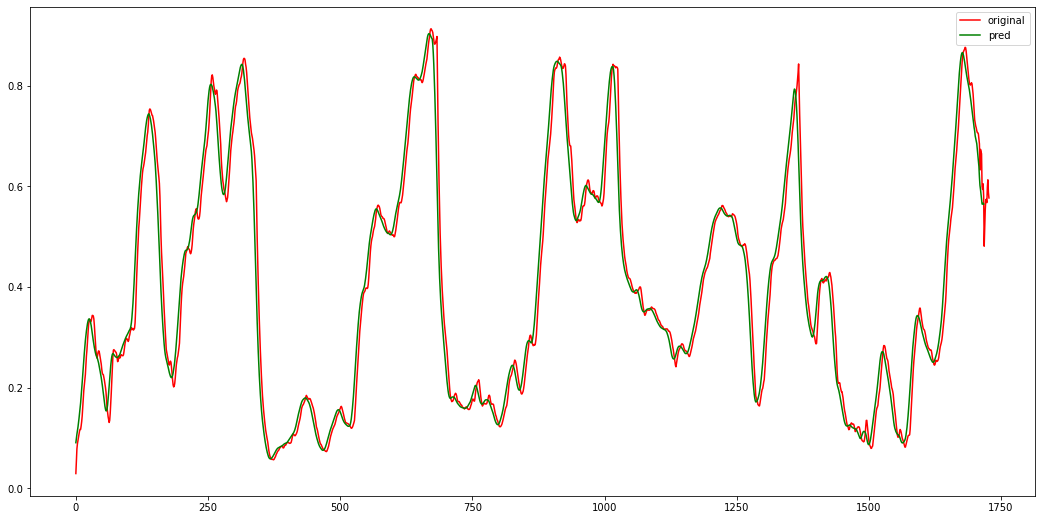

In [247]:
plt.figure(figsize = (18,9))
plt.plot(all_mid,color="red",label="original")
plt.plot(pred,color="green",label="pred")
plt.legend()
plt.show()

In [248]:
window_size=10
ema_pred=[]
ema_mse=[]
ema=train_mid[0]
alpha=0.5
for i in range(1,len(train_mid)):
    ema=ema*(1-alpha)+all_mid[i]*alpha
    ema_pred.append(ema)
    sq=np.square(all_mid[i]-ema_pred[-1])
    ema_mse.append(sq)
print(np.mean(ema_mse))

0.00010915038920486328


In [249]:
window_size=10
ema_mse=[]
pred=[]
alpha=0.5
l=len(train_mid)
for i in range(len(test_mid)-1):
    ema=ema*(1-alpha)+test_mid[i]*alpha
    pred.append(ema)
    sq=np.square(test_mid[i+1]-pred[-1])
    ema_mse.append(sq)
print(np.mean(ema_mse))

0.0014368407828410368


In [250]:
buy_sell=[]
for i in range(len(test_mid)-1):
    if pred[i]-test_mid[i]>0:
        buy_sell.append(1)
    else:
        buy_sell.append(0)
real=[]
for i in range(len(test_mid)-1):
    if test_mid[i+1]-test_mid[i]>0:
        real.append(1)
    else:
        real.append(0)
confusion_matrix(real,buy_sell)

array([[4, 5],
       [4, 4]], dtype=int64)

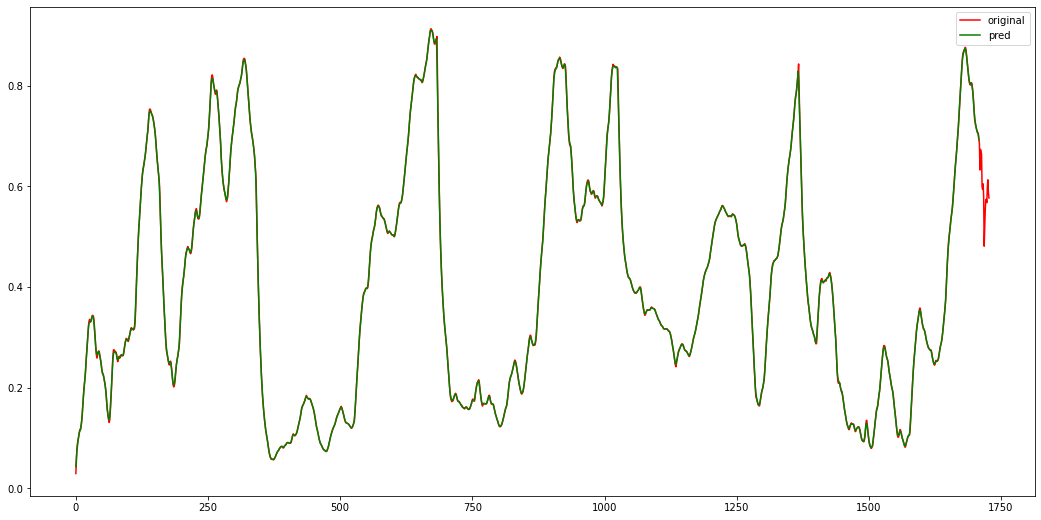

In [251]:
plt.figure(figsize = (18,9))
plt.plot(all_mid,color="red",label="original")
plt.plot(ema_pred,color="green",label="pred")
plt.legend()
plt.show()

In [252]:
class DataGenerator(object):
    def __inint__(self,data,window_size,batch_size):
        self.data=data
        self.window_size=window_size
        self.batch_size=batch_size
        self.steps=len(self.data)-self.window_size
        self.segments=self.steps//self.batch_size
        self.index=np.arange(self.steps)
        self.cursor=[i*self.segments for i in range(self.batch_size)]
        self.on_epoch_end()

    def next_batch(self):
        batch_data=np.zeros((self.batch_size),dtype=np.float32)
        batch_label=np.zeros((self.batch_size),dtype=np.float32)

        for i in range(self.batch_size):
            if self.cursor[i]+1>=self.steps:
                self.cursor[i]=np.random.randint(0,(i+1)*self.steps)

In [253]:
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

In [254]:
len(train_mid)

1710

In [255]:
len(test_mid)

18

In [256]:
def create_data(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [257]:
trainX,trainY=create_data(train_mid,1)
testX,testY=create_data(test_mid,1)

In [258]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [259]:
model= Sequential()
model.add(LSTM(50,input_dim=1,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='adam')

In [260]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=40,
    validation_split=0.02)

Epoch 1/40
14/14 [==============================] - 5s 45ms/step - loss: 0.1748 - val_loss: 0.4764
Epoch 2/40
14/14 [==============================] - 0s 10ms/step - loss: 0.1061 - val_loss: 0.2785
Epoch 3/40
14/14 [==============================] - 0s 7ms/step - loss: 0.0465 - val_loss: 0.0918
Epoch 4/40
14/14 [==============================] - 0s 7ms/step - loss: 0.0256 - val_loss: 0.0328
Epoch 5/40
14/14 [==============================] - 0s 7ms/step - loss: 0.0228 - val_loss: 0.0443
Epoch 6/40
14/14 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0383
Epoch 7/40
14/14 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.0221
Epoch 8/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0125
Epoch 9/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 10/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 11/40
14/14

In [261]:
def prediction(model,testX):
    predict=model.predict(testX)
    predict=predict.reshape(-1)
    return predict

In [262]:
pred=prediction(model,testX)

In [263]:
window_size=10
mse=[]
for j in range(len(testY)):
    sq=np.square(testY[j]-pred[j])
    mse.append(sq)
print(np.mean(mse))

0.0015883919763633428


In [264]:
buy_sell=[]
for i in range(len(pred)-1):
    if pred[i]-testY[i]>0:
        buy_sell.append(1)
    else:
        buy_sell.append(0)
real=[]
for i in range(len(pred)-1):
    if testY[i+1]-testY[i]>0:
        real.append(1)
    else:
        real.append(0)
confusion_matrix(real,buy_sell)

array([[6, 2],
       [6, 1]], dtype=int64)

In [265]:
print(np.mean(ema_mse))

0.0014368407828410368


In [266]:
print(-np.mean(ema_mse)+np.mean(mse))

0.00015155119352230602
